In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
from google.colab import files
files.upload()  # select kaggle.json

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"diljeetpahuja","key":"a693d899ec2cfe173d0e819d19715d3e"}'}

In [8]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [9]:
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
brats20-dataset-training-validation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
!unzip brats20-dataset-training-validation.zip -d /content/dataset/

Archive:  brats20-dataset-training-validation.zip
replace /content/dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii  
  inflating: /content/dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii  
  inflating: /content/dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii  
  inflating: /content/dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii  
  inflating: /content/dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii  
  inflating: /content/dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002

In [11]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import cv2

In [19]:
base_path = "/content/dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"  # check exact folder name
patients = os.listdir(base_path)
print("Total patients:", len(patients))
print("Example folder:", patients[0])

Total patients: 371
Example folder: BraTS20_Training_253


In [20]:
def load_patient_modalities(patient_path):
    # har modality ka path
    t1_path = [os.path.join(patient_path, f) for f in os.listdir(patient_path) if "t1.nii" in f and "t1ce" not in f][0]
    t1ce_path = [os.path.join(patient_path, f) for f in os.listdir(patient_path) if "t1ce.nii" in f][0]
    t2_path = [os.path.join(patient_path, f) for f in os.listdir(patient_path) if "t2.nii" in f][0]
    flair_path = [os.path.join(patient_path, f) for f in os.listdir(patient_path) if "flair.nii" in f][0]
    seg_path = [os.path.join(patient_path, f) for f in os.listdir(patient_path) if "seg.nii" in f][0]

    # nibabel se load
    t1 = nib.load(t1_path).get_fdata()
    t1ce = nib.load(t1ce_path).get_fdata()
    t2 = nib.load(t2_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()
    seg = nib.load(seg_path).get_fdata()

    return t1, t1ce, t2, flair, seg



In [22]:
sample_path = os.path.join(base_path, patients[0])
t1, t1ce, t2, flair, seg = load_patient_modalities(sample_path)

print("Shapes:")
print("T1:", t1.shape)
print("T1ce:", t1ce.shape)
print("T2:", t2.shape)
print("FLAIR:", flair.shape)
print("Seg:", seg.shape)


Shapes:
T1: (240, 240, 155)
T1ce: (240, 240, 155)
T2: (240, 240, 155)
FLAIR: (240, 240, 155)
Seg: (240, 240, 155)


In [23]:
def normalize(img):
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img


In [24]:
t1 = normalize(t1)
t1ce = normalize(t1ce)
t2 = normalize(t2)
flair = normalize(flair)


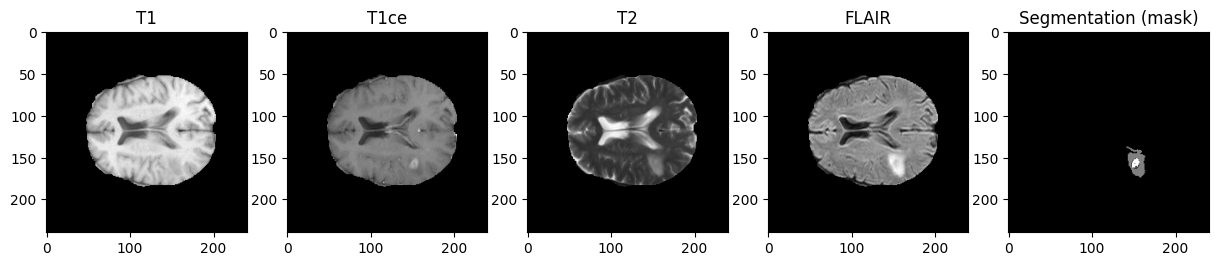

In [25]:
slice_idx = 80

plt.figure(figsize=(15,5))

plt.subplot(1,5,1)
plt.imshow(t1[:,:,slice_idx], cmap='gray')
plt.title("T1")

plt.subplot(1,5,2)
plt.imshow(t1ce[:,:,slice_idx], cmap='gray')
plt.title("T1ce")

plt.subplot(1,5,3)
plt.imshow(t2[:,:,slice_idx], cmap='gray')
plt.title("T2")

plt.subplot(1,5,4)
plt.imshow(flair[:,:,slice_idx], cmap='gray')
plt.title("FLAIR")

plt.subplot(1,5,5)
plt.imshow(seg[:,:,slice_idx], cmap='gray')
plt.title("Segmentation (mask)")

plt.show()


In [31]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# Dataset path
base_path = "/content/dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

def normalize(img):
    """Normalize image to 0–1 range"""
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-5)

def resize_slice(img, size=(128, 128)):
    """Resize MRI slice"""
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

X = []
y = []

# Take limited patients to avoid Colab crash
patients = os.listdir(base_path)[:10]

for p in patients:
    p_path = os.path.join(base_path, p)
    files = os.listdir(p_path)

    # Find all modalities
    t1 = nib.load(os.path.join(p_path, [f for f in files if "_t1.nii" in f][0])).get_fdata()
    t1ce = nib.load(os.path.join(p_path, [f for f in files if "_t1ce.nii" in f][0])).get_fdata()
    t2 = nib.load(os.path.join(p_path, [f for f in files if "_t2.nii" in f][0])).get_fdata()
    flair = nib.load(os.path.join(p_path, [f for f in files if "_flair.nii" in f][0])).get_fdata()
    seg = nib.load(os.path.join(p_path, [f for f in files if "_seg.nii" in f][0])).get_fdata()

    # Iterate slices (take few slices for demo)
    for i in range(40, 70):  # choose mid slices
        t1_s, t1ce_s, t2_s, flair_s, seg_s = (
            resize_slice(normalize(t1[:, :, i])),
            resize_slice(normalize(t1ce[:, :, i])),
            resize_slice(normalize(t2[:, :, i])),
            resize_slice(normalize(flair[:, :, i])),
            resize_slice(seg[:, :, i])
        )

        # Stack 4 modalities as channels → (128,128,4)
        X.append(np.stack([t1_s, t1ce_s, t2_s, flair_s], axis=-1))
        y.append(seg_s)

X = np.array(X)
y = np.array(y)[..., np.newaxis]

print("Input shape (multi-modal):", X.shape)
print("Mask shape:", y.shape)



Input shape (multi-modal): (300, 128, 128, 4)
Mask shape: (300, 128, 128, 1)


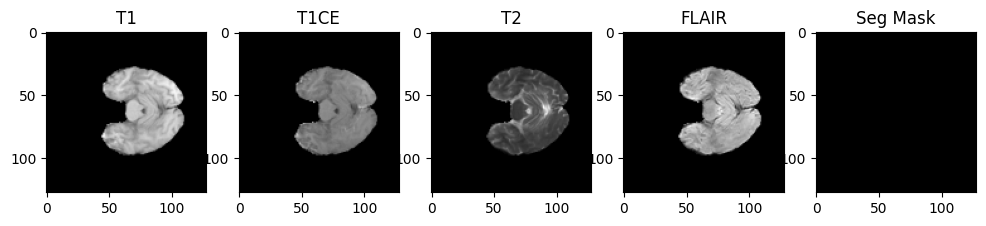

In [32]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 5, 1); plt.imshow(X[0][:,:,0], cmap='gray'); plt.title("T1")
plt.subplot(1, 5, 2); plt.imshow(X[0][:,:,1], cmap='gray'); plt.title("T1CE")
plt.subplot(1, 5, 3); plt.imshow(X[0][:,:,2], cmap='gray'); plt.title("T2")
plt.subplot(1, 5, 4); plt.imshow(X[0][:,:,3], cmap='gray'); plt.title("FLAIR")
plt.subplot(1, 5, 5); plt.imshow(y[0].squeeze(), cmap='gray'); plt.title("Seg Mask")
plt.show()


In [34]:
model = unet_model(input_size=(128, 128, 4))  # 4 channels
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X, y,
    epochs=20,
    batch_size=4,
    validation_split=0.1
)


Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 48s 587ms/step - accuracy: 0.9486 - loss: 0.3978 - val_accuracy: 0.9215 - val_loss: 0.2369
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 40s 571ms/step - accuracy: 0.9751 - loss: 0.1007 - val_accuracy: 0.9212 - val_loss: 0.2294
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 613ms/step - accuracy: 0.9522 - loss: 0.0609 - val_accuracy: 0.9201 - val_loss: 0.0514
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 40s 596ms/step - accuracy: 0.9604 - loss: 0.1012 - val_accuracy: 0.9139 - val_loss: -0.1244
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 602ms/step - accuracy: 0.9454 - loss: 0.0686 - val_accuracy: 0.9199 - val_loss: -0.1315
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 40s 595ms/step - accuracy: 0.9546 - loss: 0.0871 - val_accuracy: 0.9208 - val_loss: 0.0121
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 48s 698ms/step - accuracy: 0.9500 - loss: 0.0597 - val_accuracy: 0.9182 - val_loss: -0.1255
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 75s 596ms/step - accuracy: 0.9493 - loss: 0.0374 - val_a

In [35]:
base_path = "/content/dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"


In [36]:
import os

patients = os.listdir(base_path)
print("Total patients:", len(patients))
print(patients[:5])  # pehle 5 dekh lo


Total patients: 371
['BraTS20_Training_253', 'BraTS20_Training_050', 'BraTS20_Training_293', 'BraTS20_Training_072', 'BraTS20_Training_251']


In [37]:
import nibabel as nib
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def load_brats_patient(patient_path):
    """Load one patient's modalities and mask"""
    modalities = ['flair', 't1', 't1ce', 't2']
    images = []
    for m in modalities:
        img_path = [f for f in os.listdir(patient_path) if m in f][0]
        img = nib.load(os.path.join(patient_path, img_path)).get_fdata()
        images.append(img)

    mask_path = [f for f in os.listdir(patient_path) if 'seg' in f][0]
    mask = nib.load(os.path.join(patient_path, mask_path)).get_fdata()

    # Stack modalities into channels
    image = np.stack(images, axis=-1)
    return image, mask

def normalize_volume(volume):
    """Normalize each MRI modality"""
    volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume))
    volume = np.clip(volume, 0, 1)
    return volume

# Load only a few patients (due to large size)
X, y = [], []
for i, patient in enumerate(patients[:10]):  # 10 patients for now
    path = os.path.join(base_path, patient)
    image, mask = load_brats_patient(path)

    # pick a few middle slices only
    for slice_idx in range(60, 80, 2):  # 10 slices
        img_slice = normalize_volume(image[:, :, slice_idx, :])
        mask_slice = (mask[:, :, slice_idx] > 0).astype(np.uint8)

        X.append(img_slice)
        y.append(mask_slice)

X = np.array(X)
y = np.expand_dims(np.array(y), axis=-1)
print("Images shape:", X.shape, "Masks shape:", y.shape)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Images shape: (100, 240, 240, 4) Masks shape: (100, 240, 240, 1)


In [38]:
from tensorflow.keras import layers, models

def unet_model(input_shape=(240, 240, 4)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.UpSampling2D((2,2))(c4)
    u5 = layers.Concatenate()([u5, c3])
    c5 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D((2,2))(c5)
    u6 = layers.Concatenate()([u6, c2])
    c6 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2,2))(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c7)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = unet_model(input_shape=X_train.shape[1:])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 240, 240,  │      1,184 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 240, 240,  │      9,248 │ conv2d_45[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 120, 120,  │          0 │ conv2d_46[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 120, 120,  │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 120, 120,  │     36,928 │ conv2d_47[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 60, 60,    │          0 │ conv2d_48[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 60, 60,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 60, 60,    │    147,584 │ conv2d_49[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 30, 30,    │          0 │ conv2d_50[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 30, 30,    │    295,168 │ max_pooling2d_11… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 30, 30,    │    590,080 │ conv2d_51[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 60, 60,    │          0 │ conv2d_52[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 60, 60,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_50[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 60, 60,    │    442,496 │ concatenate_9[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 60, 60,    │    147,584 │ conv2d_53[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 120, 120,  │          0 │ conv2d_54[0][0] 

 Total params: 1,947,169 (7.43 MB)

 Trainable params: 1,947,169 (7.43 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=4
)


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 151s 7s/step - accuracy: 0.8904 - loss: 0.4689 - val_accuracy: 0.9721 - val_loss: 0.0949
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.9643 - loss: 0.1139 - val_accuracy: 0.9721 - val_loss: 0.0936
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 140s 7s/step - accuracy: 0.9602 - loss: 0.1212 - val_accuracy: 0.9721 - val_loss: 0.0939
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 152s 8s/step - accuracy: 0.9580 - loss: 0.1132 - val_accuracy: 0.9721 - val_loss: 0.0931
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 144s 7s/step - accuracy: 0.9663 - loss: 0.1034 - val_accuracy: 0.9721 - val_loss: 0.0749
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 139s 7s/step - accuracy: 0.9673 - loss: 0.0814 - val_accuracy: 0.9721 - val_loss: 0.0755
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - accuracy: 0.9660 - loss: 0.0756 - val_accuracy: 0.9783 - val_loss: 0.0518
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - accuracy: 0.9762 - loss: 0.0670 - val_accuracy: 0.9830 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


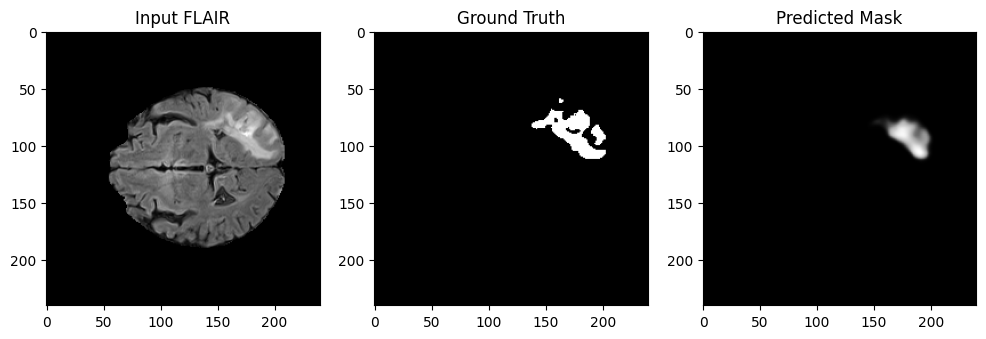

In [40]:
import matplotlib.pyplot as plt

# Prediction on one validation image
pred = model.predict(np.expand_dims(X_val[0], axis=0))[0, :, :, 0]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(X_val[0][:,:,0], cmap='gray')
plt.title("Input FLAIR")
plt.subplot(1,3,2)
plt.imshow(y_val[0][:,:,0], cmap='gray')
plt.title("Ground Truth")
plt.subplot(1,3,3)
plt.imshow(pred, cmap='gray')
plt.title("Predicted Mask")
plt.show()


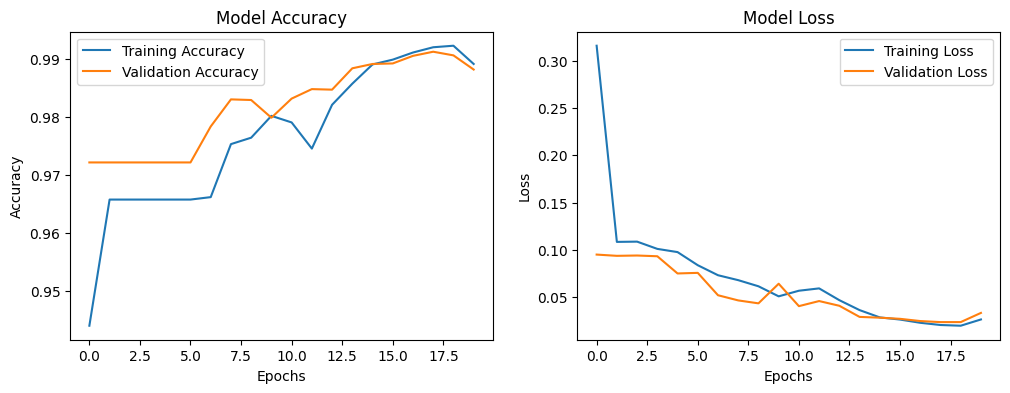

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [42]:
import tensorflow as tf
import numpy as np

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

# Evaluate on validation set
preds = model.predict(X_val)
preds_bin = (preds > 0.5).astype(np.uint8)

dice_scores, iou_scores = [], []
for i in range(len(y_val)):
    dice_scores.append(dice_coefficient(y_val[i], preds_bin[i]).numpy())
    iou_scores.append(iou_score(y_val[i], preds_bin[i]).numpy())

print("Average Dice Coefficient:", np.mean(dice_scores))
print("Average IoU:", np.mean(iou_scores))


1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
Average Dice Coefficient: 0.741377
Average IoU: 0.6153946


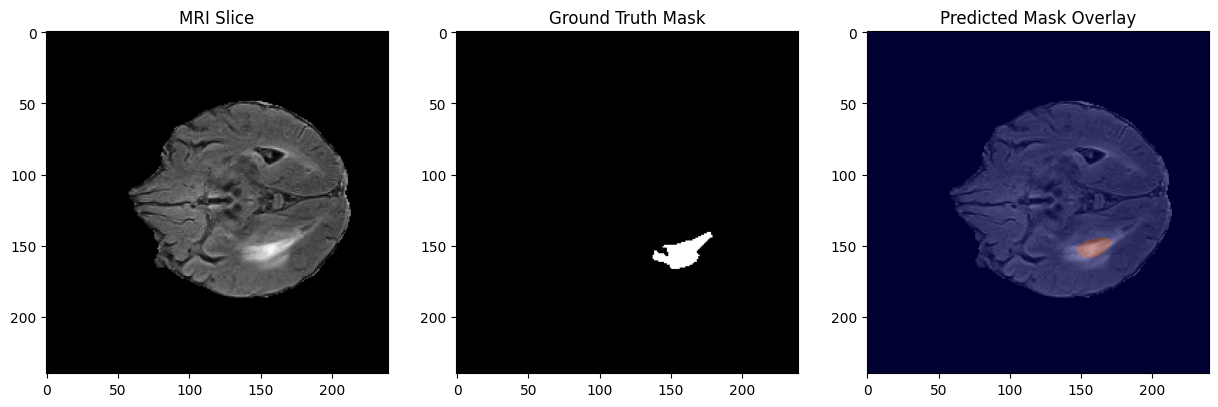

In [43]:
import matplotlib.pyplot as plt

idx = 2  # choose any validation image
image = X_val[idx][:, :, 0]  # FLAIR channel
true_mask = y_val[idx][:, :, 0]
pred_mask = preds_bin[idx][:, :, 0]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(image, cmap='gray')
plt.title("MRI Slice")

plt.subplot(1,3,2)
plt.imshow(true_mask, cmap='gray')
plt.title("Ground Truth Mask")

plt.subplot(1,3,3)
plt.imshow(image, cmap='gray')
plt.imshow(pred_mask, cmap='jet', alpha=0.4)
plt.title("Predicted Mask Overlay")
plt.show()


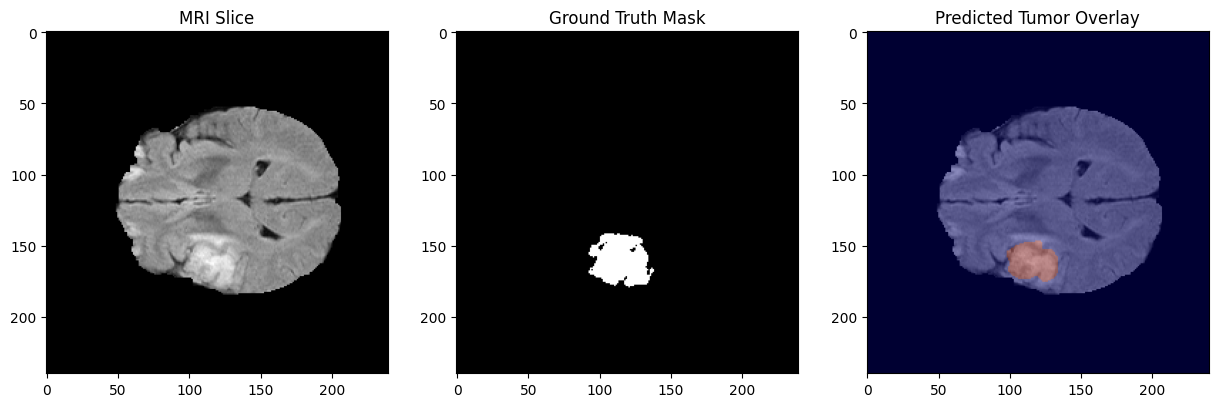

In [44]:
import matplotlib.pyplot as plt

idx = 3  # kisi bhi validation sample ka index choose karo
image = X_val[idx][:, :, 0]     # FLAIR or T1 channel
true_mask = y_val[idx][:, :, 0]
pred_mask = preds_bin[idx][:, :, 0]

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(image, cmap='gray')
plt.title("MRI Slice")

plt.subplot(1,3,2)
plt.imshow(true_mask, cmap='gray')
plt.title("Ground Truth Mask")

plt.subplot(1,3,3)
plt.imshow(image, cmap='gray')
plt.imshow(pred_mask, cmap='jet', alpha=0.4)
plt.title("Predicted Tumor Overlay")

plt.show()


In [48]:
# Calculate pixel-wise accuracy
accuracy = np.mean(preds_bin == y_val)
print("Pixel-wise Accuracy:", round(accuracy * 100, 2), "%")

Pixel-wise Accuracy: 98.81 %


In [45]:
import pandas as pd

results_df = pd.DataFrame({
    'Patient': range(len(dice_scores)),
    'Dice Coefficient': dice_scores,
    'IoU': iou_scores
})

results_df.to_csv("/content/segmentation_results.csv", index=False)
results_df.head()


,Patient,Dice Coefficient,IoU
0,0,0.474986,0.311463
1,1,0.856128,0.748447
2,2,0.555102,0.384181
3,3,0.776401,0.634522
4,4,0.548124,0.377528


In [46]:
import numpy as np

# Save trained model
model.save("/content/brain_tumor_segmentation_model.h5")
print("✅ Model saved successfully!")

# Save predictions and sample arrays
np.save("/content/X_val.npy", X_val)
np.save("/content/y_val.npy", y_val)
np.save("/content/preds_bin.npy", preds_bin)

print("✅ Data saved successfully!")


✅ Model saved successfully!
✅ Data saved successfully!


In [47]:
from google.colab import files

files.download("/content/brain_tumor_segmentation_model.h5")
files.download("/content/X_val.npy")
files.download("/content/y_val.npy")
files.download("/content/preds_bin.npy")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>